<a href="https://colab.research.google.com/github/abdulmukit98/Tensorflow-in-practice-specialization/blob/master/forcasting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 51kB/s 
     |████████████████████████████████| 501kB 54.6MB/s 
     |████████████████████████████████| 3.1MB 51.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


The next code block will set up the time series with seasonality, trend and a bit of noise.

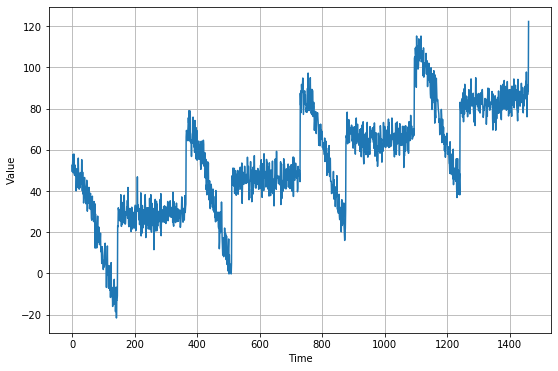

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where( season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time)
                  )
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)
  
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(9,6))
plot_series(time, series)
plt.show()

Now we have the time series, lets split it so we can start forecasting

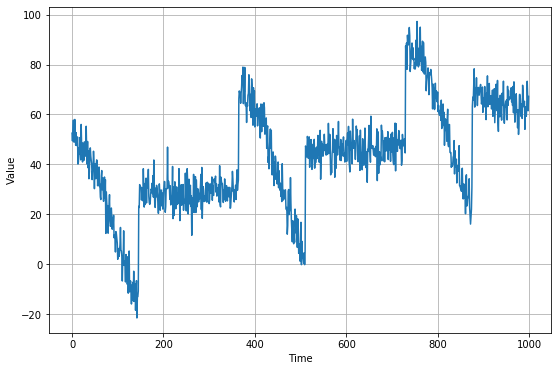

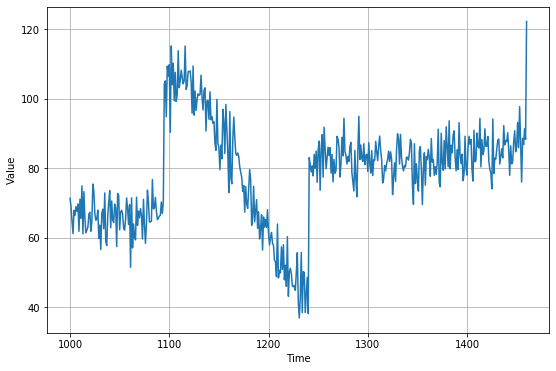

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(9,6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plt.show()

#Naive Forecast

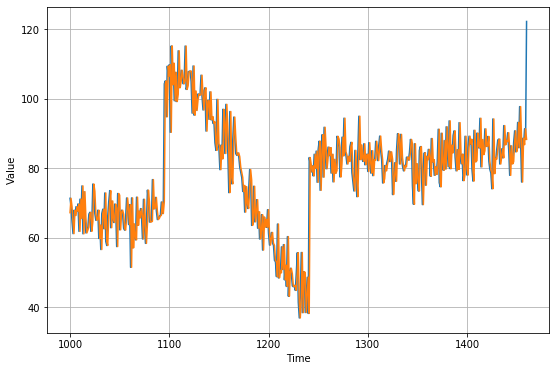

In [5]:
naive_forecast = series[split_time - 1 : -1]

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

lets zoom it on start of validation period

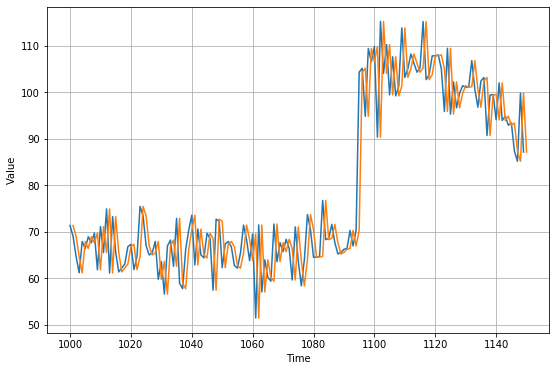

In [6]:
plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)


you can see that naice forcast lag 1 step behind the time series


Now lets compute the mean squared error and the absolute error between forevaast and the prediction in validation period.



In [7]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.937908


Thats our baseline, now lets try a moving avarage


In [0]:
def moving_avarage_forecast(series, window_size):
  """Forecasting the mean of last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time : time+window_size].mean())
  return np.array(forecast)

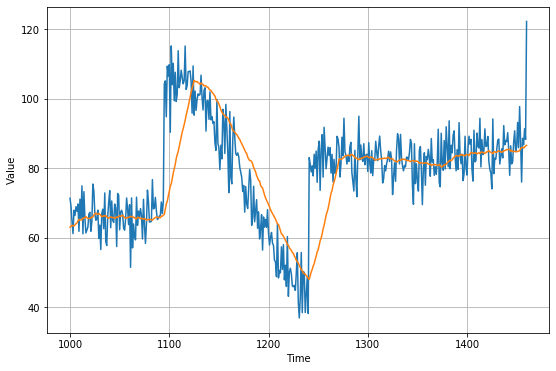

In [9]:
moving_avg = moving_avarage_forecast(series,30)[split_time - 30:]

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [10]:
print(keras.metrics.mean_squared_error(x_valid,moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


Thats worse than naive forecast! The moving avarage does not anticipate trend or seasonality, so lets try to remove them by using differencing. Since  seasionality period is 365 days, we will substract the value at time t-365 from the value at time t.

<function matplotlib.pyplot.show>

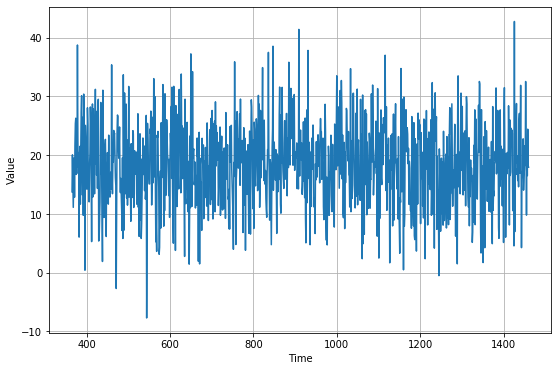

In [11]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(9,6))
plot_series(diff_time, diff_series)
plt.show

Great, the trend and seasonality seems tobe gone, so now we can use the moving avarage:

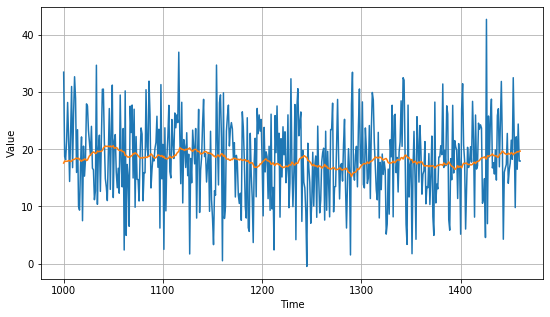

In [15]:
diff_moving_avg = moving_avarage_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(9,5))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now lets bring back the trend and seasonality by adding the past vaalues from t-365:

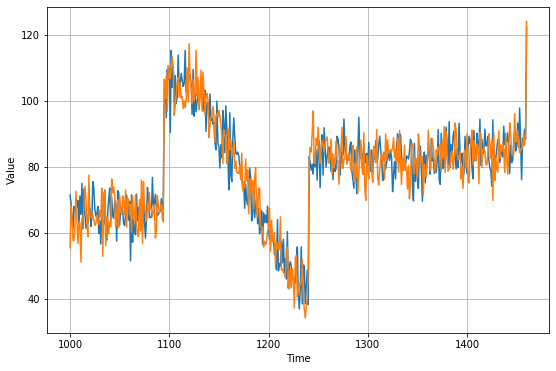

In [18]:
diff_moving_avg_plus_past = series[split_time - 365: -365] + diff_moving_avg

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [20]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past value, which were noisy.

Lets use a moving avaraging on past value to remove some of the noise


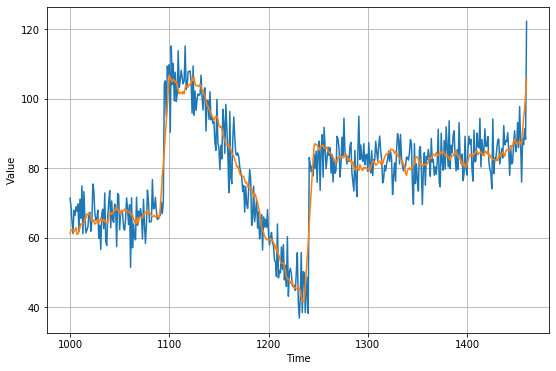

In [22]:
diff_moving_avg_plus_smooth_past = moving_avarage_forecast(series[split_time - 370: -360], 10) + diff_moving_avg

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [24]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442
